In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from PIL import Image
import cv2 as cv
from datetime import datetime
from torchvision import models, datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset
import os
from pathlib import Path
import segmentation_models_pytorch as smp
from keras.utils import to_categorical

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [22]:
no_masks_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\train\no_masks"
json_file=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\polygons.jsonl"
img_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\imgs"

pseudo_path = r"pseudo_labeled_masks.csv"

## 3 Models predictions on unlabeled data

In [23]:
class HubmapDatasetPseudolabels(Dataset):
    
        def __init__(self, json_file, img_path, no_masks_path, models):
#             self.polygons = json_file
            self.img_path = img_path
            self.no_masks_list = no_masks_path
            self.no_masks_path = no_masks_path
#             assert isinstance(model, nn.Module)
            self.models = models
    
        def __len__(self):
            return len(self.no_masks_list)
        
        @property
        def no_masks_list(self):
            return self.__no_masks_list
        
        @no_masks_list.setter
        def no_masks_list(self, path):
            self.__no_masks_list = os.listdir(path)
        

        @staticmethod
        def image_to_inputs(image):
            
            inputs = np.array(image).transpose((2, 0, 1))
            inputs = inputs/inputs.max()

            norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            inputs = norm(torch.tensor(inputs.astype(np.float32)))
            inputs = inputs.unsqueeze(0)
            
            return inputs
    
        def __getitem__(self, index):
            if torch.is_tensor(index):
                index = index.tolist()
            
            img_name = os.path.join(self.no_masks_path,self.no_masks_list[index])
            
            with Image.open(img_name) as image:           
                inputs = self.image_to_inputs(image)
                
            inputs = inputs.to(device)
            
            outputs = []
            for model in self.models:
                outputs.append(model(inputs))
            
            outputs_tensor = torch.stack(outputs)
            outputs_mean = torch.mean(outputs_tensor, dim=0)
            outputs_mean[outputs_mean<0.65] = 0
            
            outputs.clear()
            
            outputs_argmax = torch.argmax(outputs_mean, dim=1)
            
            torch.cuda.empty_cache()
            
            return (inputs, outputs_argmax)

In [24]:
# Сохраняем псевдолейблы

def save_pseudo_masks():
    
    img_names_list = []
    masks_list = []
    
    for index in range(len(dataset)):
        img_name = dataset.no_masks_list[index]
        
        image, mask = dataset[index]
        
        mask_numpy = mask = mask.squeeze().detach().cpu().numpy()
        labels = np.unique(mask_numpy)
        
        mask_decoded = {}
        for label in labels[1:]:
            col, row = np.where(mask_numpy == label)
#             coordinates_list = [(x[i],y[i]) for i in range(len(x))]  
            coordinates_list = (list(col), list(row))
            
            mask_decoded[label] = coordinates_list
#         print(coordinates_list)
#         print(mask_decoded)
            
        img_names_list.append(img_name)
        masks_list.append(mask_decoded)
        
#         coordinates_list.clear()
#         mask_decoded.clear()
        
        
    pseudo_labels = {'id': img_names_list, 'labels': masks_list}

    pseudo_labels_df = pd.DataFrame.from_dict(pseudo_labels)
    
    return pseudo_labels_df

In [25]:
dataset = HubmapDatasetPseudolabels(json_file, img_path, no_masks_path, [model, model2])

In [26]:
df = save_pseudo_masks()

In [168]:
# df.values[0]

In [30]:
df.head()

,id,labels
0,000e79e206b7.tif,"{1: ([14, 14, 15, 41, 41, 41, 41, 42, 42, 42, ..."
1,00176a88fdb0.tif,"{1: ([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2..."
2,00359ab8338b.tif,"{1: ([144, 144, 144, 144, 145, 145, 145, 145, ..."
3,00488ca285ee.tif,"{1: ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,004fb033dd09.tif,"{1: ([54, 54, 55, 55, 55, 56, 56, 56, 57, 57, ..."


In [31]:
df.to_json('pseudo_labeled_masks_3.json')

## MODELS for predictions

In [20]:
model = smp.Unet(encoder_name='mit_b3',
                 classes=3, 
                 decoder_channels=(512, 512, 256, 128, 32),
                 decoder_use_batchnorm=True,
                 activation=None,
                 encoder_weights='imagenet')

model.segmentation_head[2] = nn.Softmax(dim=1)

model = model.float()

model.to(device)

model.load_state_dict(torch.load('models/HuBMAP_U_mit_b3_wsi_XIV_pt2.pt'))

<All keys matched successfully>

In [21]:
model2 = smp.Unet(encoder_name='mit_b4',
                  classes=3,
                  decoder_channels=(512, 256, 128, 64, 32),
                  decoder_use_batchnorm=True,
                  activation=None,
                  encoder_weights='imagenet')

model2.segmentation_head[2] = nn.Softmax(dim=1)

model2 = model2.float()

model2.to(device)

model2.load_state_dict(torch.load('models/HuBMAP_U_mit_b3_wsi_XVII.pt'))

<All keys matched successfully>

In [6]:
# model3 = smp.Unet(encoder_name='resnet34',
#                  classes=4,
#                  activation=None,
#                  encoder_weights='imagenet')

# model3.segmentation_head[2] = nn.Softmax(dim=1)

# model3 = model3.float()

# model3.to(device)

# model3.load_state_dict(torch.load('models/HuBMAP_U_r34_wsi_rec _X_mk1.pt'))

<All keys matched successfully>

## Pseudo labeled DATA LOADING

In [3]:
no_masks_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\train\no_masks"
json_file=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\polygons.jsonl"
img_path=r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\imgs"

pseudo_path = r"pseudo_labeled_masks_3.json"

In [33]:
with open(pseudo_path) as file:
    pseudo_file = pd.read_json(file)

In [34]:
pseudo_file.head()

,id,labels
0,000e79e206b7.tif,"{'1': [[14, 14, 15, 41, 41, 41, 41, 42, 42, 42..."
1,00176a88fdb0.tif,"{'1': [[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2,..."
2,00359ab8338b.tif,"{'1': [[144, 144, 144, 144, 145, 145, 145, 145..."
3,00488ca285ee.tif,"{'1': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,004fb033dd09.tif,"{'1': [[54, 54, 55, 55, 55, 56, 56, 56, 57, 57..."


In [4]:
class PseudoDataSet(Dataset):
    
    def __init__(self, pseudo_path, no_masks_path):
        with open(pseudo_path) as file:
            self.pseudo_file = pd.read_json(file)
        self.img_path = no_masks_path
    
    def __len__(self):
        return len(self.pseudo_file)
    
    # Потом вставить def transformation
    def transformation(self, image, mask):
        
        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
        crop_params = transforms.RandomCrop.get_params(image,output_size=(400,400))            

        flip = np.random.random()
        crop = np.random.random()
        flip_v = np.random.random()
        pad = np.random.random()
        jitter = np.random.random()

#         if pad > 0.7:
#             image = transforms.Pad(40, padding_mode='constant')(image)
#             image = transforms.Resize((512,512))(image)

        if jitter > 0.3:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)

        image = TF.rotate(image,rotate_params)

        if flip > 0.7:
            image = TF.hflip(image)

        if flip_v > 0.7:
            image = TF.vflip(image)

        if crop > 0.7:
            image = TF.resized_crop(image,*crop_params,(512,512))

        mask_img = Image.fromarray(mask)

#         if pad > 0.7:
#             mask_img = transforms.Pad(40, padding_mode='constant')(mask_img)
#             mask_img = transforms.Resize((512,512))(mask_img)

        mask_img = TF.rotate(mask_img,rotate_params)

        if flip > 0.7:
            mask_img = TF.hflip(mask_img)

        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)

        if crop > 0.7:
            mask_img = TF.resized_crop(mask_img,*crop_params,(512,512))

        mask = (np.array(mask_img))            

        return (image, mask)
    
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        img_name = os.path.join(self.img_path,
                               self.pseudo_file.id[index])

        image = Image.open(img_name)
        
        n_targets = [int(n) for n in self.pseudo_file.labels[index].keys()]
        
        self.mask = np.zeros((512, 512), dtype=np.uint8)
        
        # каждый класс на отдельную маску
        for n in (n_targets):
            label = n
            if label == 3:
                continue
            col, row = self.pseudo_file.labels[index][str(label)]
            self.mask[col, row] = label
    
        if True:
            image, self.mask = self.transformation(image, self.mask)
        
#         mask = self.mask_stack[0]
#         for i in range(1, n_targets):
#             mask = cv.bitwise_xor(mask, self.mask_stack[i])
#         mask[np.isnan(mask)] = 0  
        
        image = np.array(image).transpose((2, 0, 1))
        image = image/image.max()
        
        image = norm(torch.tensor(image.astype(np.float32)))
        
#         self.mask = np.expand_dims(self.mask, 0)
    
        sample = (image, self.mask.astype(np.float32))
        
        return sample

In [5]:
dataset = PseudoDataSet(pseudo_path, no_masks_path)

In [6]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

# torch.save(train_data, 'data\TRAIN_DATA_split_2.pt')
# torch.save(test_data, 'data\TEST_DATA_split_2.pt')

In [7]:
batch_size = 8

train_loader = DataLoader(train_data,
                        batch_size=batch_size,
                       shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                       shuffle=False)

In [8]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    plt.imshow(masked_img)
    
def img_denorm(x):
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)
    
    return x

torch.Size([8, 512, 512])
uint8 255


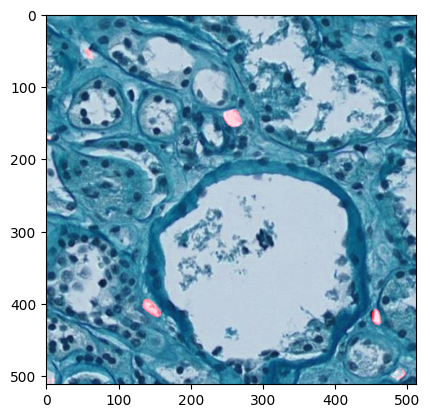

In [9]:
for img, msk in train_loader:
    print(msk.shape)
    img, msk = img[0], msk[0]
    img, msk = img.numpy().transpose((1,2,0)), msk.numpy()
    img, msk = img_denorm(img), msk.astype(np.uint8)
    if msk.max():
        msk = msk*(255//msk.max())
    print(img.dtype, msk.max())
    
    
    show_masked(img, msk)
    break

## MODEL for training

In [10]:
model = smp.Unet(encoder_name='mit_b3',
                 encoder_weights='imagenet',
                 decoder_channels=(512, 256, 128, 64, 32),
                 decoder_use_batchnorm=True,
                 classes=3,activation=None)


model.segmentation_head[2] = nn.Softmax(dim=1)

# Loss_func = nn.CrossEntropyLoss(weight=class_weights)
dice_loss = smp.losses.DiceLoss(mode='multiclass')
focal_loss = smp.losses.FocalLoss(mode='multiclass')
# Loss_func = dice_loss + (1 * focal_loss)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-04, weight_decay=5e-04)

model = model.float()

model.to(device)

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64

In [11]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5)

In [12]:
metrics_all_classes = torchmetrics.JaccardIndex(task='multiclass', num_classes=3)

metrics = torchmetrics.JaccardIndex(task='binary')
metrics.to(device)
metrics_all_classes.to(device)

MulticlassJaccardIndex()

In [13]:
scaler = torch.cuda.amp.GradScaler()

In [14]:
n_epochs = 60
losses_train = np.zeros(n_epochs)
losses_test = np.zeros(n_epochs)
iou_test = np.zeros(n_epochs)
iou_all_test = np.zeros(n_epochs)
iou_2class = np.zeros(n_epochs)


for i in range(n_epochs):
    model.train()
    losses_epoch_train = []
    
    t0 = datetime.now()
    
    for inputs, targets in train_loader:
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(device), targets.to(device)
    
        inputs = inputs.float()
    
        optimizer.zero_grad()
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = dice_loss(outputs, targets) + (1 * focal_loss(outputs, targets))
#         loss = Loss_func(outputs, targets)

    
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        losses_epoch_train.append(loss.item())
    
    lr_scheduler.step()
    
    losses_epoch_test = []
    iou = []
    iou_all_classes = []
    iou_2class_test = []
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
        
            inputs = inputs.float()
        
            outputs = model(inputs)
            loss = dice_loss(outputs, targets) + (1 * focal_loss(outputs, targets))
#             loss = Loss_func(outputs, targets)
#             outputs_argmax = np.argmax(outputs, axis=1)
            #Фиксировать iou для класса 1
            zrs = np.zeros((targets.shape[0], targets.shape[1],targets.shape[2]), dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1 
            zrs = torch.tensor(zrs).to(device)
            
            zrs_2 = np.zeros((targets.shape[0], targets.shape[1],targets.shape[2]), dtype=np.float32)
            zrs_2[targets.cpu().numpy()==2] = 1 
            zrs_2 = torch.tensor(zrs_2).to(device)
            
            iou.append(metrics(outputs[:,1,:,:], zrs).item())
            iou_2class_test.append(metrics(outputs[:,2,:,:], zrs_2).item())
            iou_all_classes.append(metrics_all_classes(outputs, targets).item())
            
            losses_epoch_test.append(loss.item())
        
    iou_all_test[i] = np.mean(iou_all_classes)    
    iou_test[i] = np.mean(iou)    
    losses_train[i] = np.mean(losses_epoch_train) 
    losses_test[i] = np.mean(losses_epoch_test)
    iou_2class[i] = np.nanmean(iou_2class_test)
    
    if np.mean(losses_epoch_test) == np.min(losses_test[:i+1]):
        torch.save(model.state_dict(), 'best__.pt')
        print(f'Best saved, loss: {np.mean(losses_epoch_test):.3f}')
     
    if n_epochs > 100 and i == 100:
        torch.save(model.state_dict(), '100_epochs__.pt')
        print(f'100 epochs weights saved!')
        
    dt = datetime.now() - t0
    
    print(f'Epoch: {i+1}/{n_epochs}, L_train: {losses_train[i]:.3f}\
    L_test: {losses_test[i]:.3f}, Time: {dt}\
    iou_1: {iou_test[i]:.3f}, iou_2:{iou_2class[i]:.3f}, iou_a:{iou_all_test[i]:.3f}')   
    torch.cuda.empty_cache()

Best saved, loss: 1.059
Epoch: 1/60, L_train: 1.115    L_test: 1.059, Time: 0:05:07.963747    iou_1: 0.185, iou_2:0.529, iou_a:0.558


KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), 'models\HuBMAP_U_r34_pseudo_none_weights_33ep.pt')

In [ ]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

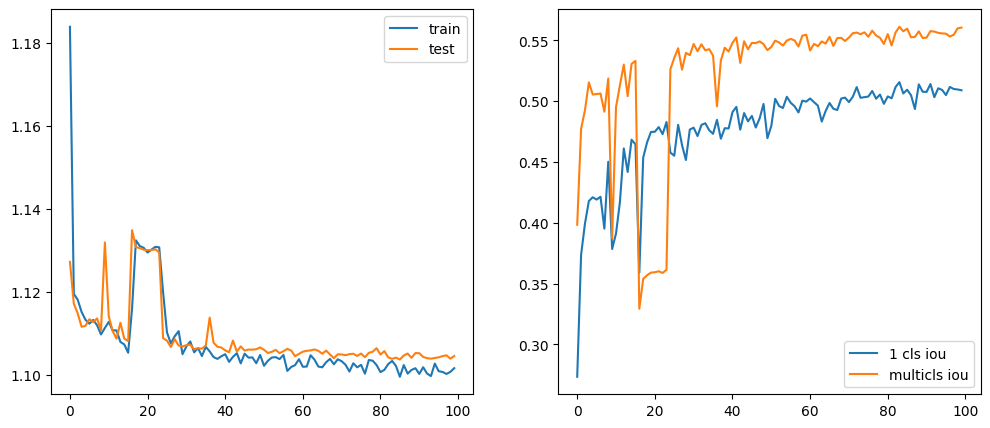

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_train[:100], label = 'train')
plt.plot(losses_test[:100], label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(iou_test[:100], label = '1 cls iou')
plt.plot(iou_all_test[:100], label = 'multicls iou')
plt.legend()

In [ ]:
# W Moving Average

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(moving_average(losses_train), label = 'train')
plt.plot(moving_average(losses_test), label='test')
plt.legend()

plt.subplot(1,2,2) 
plt.plot(moving_average(iou_test), label = '1 cls iou')
plt.plot(moving_average(iou_all_test), label = 'multicls iou')
plt.legend()

In [9]:
i = np.random.randint(0, len(pseudo_data))

image, mask = pseudo_data[i]

In [10]:
image_numpy = image.squeeze().detach().cpu().numpy().transpose((1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


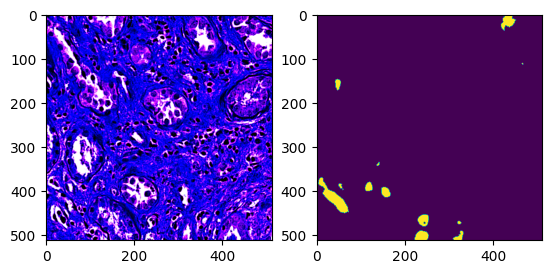

In [11]:
plt.subplot(1,2,1)
plt.imshow(image_numpy)

plt.subplot(1,2,2)
plt.imshow(mask[0])

## DATA visualisation

In [10]:
dataset = HubmapDatasetPseudolabels(json_file, img_path, no_masks_path, [model,model2,model3])

In [16]:
i = np.random.randint(0, len(dataset))

image, mask = dataset[i]

In [18]:
mask = mask.squeeze().detach().cpu().numpy()
print(np.unique(mask))

[0 1]


In [41]:
coordinates = np.where(mask == 2)

In [44]:
coordinates[0]

array([ 0,  0,  0, ..., 77, 77, 77], dtype=int64)

1


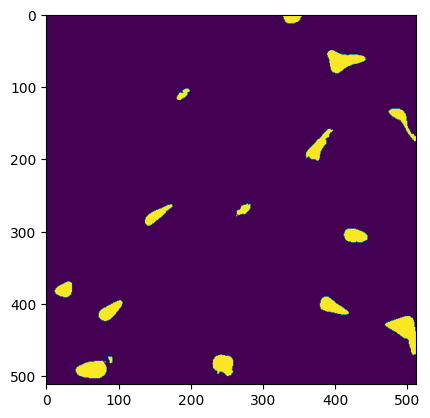

In [19]:
plt.imshow(mask)
print(mask.max())

## Stuff

In [10]:
i = np.random.randint(0, len(dataset))

image, mask = dataset[i]

In [34]:
mask = model(image)
mask2 = model2(image)
mask3 = model3(image)

In [11]:
image_numpy = image.squeeze().detach().cpu().numpy().transpose((1,2,0))

In [36]:
mask = mask.squeeze(0)
mask2 = mask2.squeeze(0)
mask3 = mask3.squeeze(0)

In [37]:
mask_numpy = mask.detach().cpu().numpy()
mask2_numpy = mask2.detach().cpu().numpy()
mask3_numpy = mask3.detach().cpu().numpy()

In [132]:
# mask_numpy[mask_numpy < 0.6] = 0
# mask2_numpy[mask2_numpy < 0.6] = 0
# mask3_numpy[mask3_numpy < 0.6] = 0

In [12]:
# mean_mask = mask.detach().cpu().numpy() + mask2.detach().cpu().numpy() + mask3.detach().cpu().numpy()
weights = np.array([1, 0.5, 0.5]).reshape(1, -1)

mean_mask = np.mean(np.array([mask_numpy,
                              mask2_numpy,
                              mask3_numpy]), axis=0)
mean_mask[mean_mask<0.65] = 0

mean_mask = np.argmax(mean_mask, axis=0)

NameError: name 'mask_numpy' is not defined

In [39]:
# mask[mask<0.8] = 0
mask_argmax = torch.argmax(mask, dim=0)
mask_argmax_numpy = mask_argmax.detach().cpu().numpy()

In [40]:
# mask2[mask2<0.8] = 0
mask2_argmax = torch.argmax(mask2, dim=0)
mask2_argmax_numpy = mask2_argmax.detach().cpu().numpy()

In [41]:
# mask3[mask3<0.8] = 0
mask3_argmax = torch.argmax(mask3, dim=0)
mask3_argmax_numpy = mask3_argmax.detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


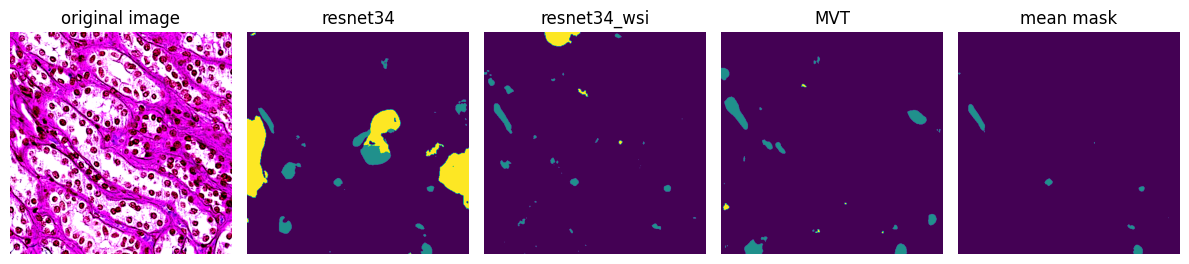

In [42]:
plt.figure(figsize=(12,12))


plt.subplot(1,5,1)
plt.imshow(image_numpy)
plt.title('original image')
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(mask_argmax_numpy)
plt.title('resnet34')
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(mask3_argmax_numpy)
plt.title('resnet34_wsi')
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(mask2_argmax_numpy)
plt.title('MVT')
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(mean_mask)
plt.title('mean mask')
plt.axis('off')

plt.tight_layout()
